In [36]:
# import libraries for reading data, exploring and plotting
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
%matplotlib inline
# library for train test split
from sklearn.model_selection import train_test_split, GridSearchCV
# deep learning libraries for text pre-processing
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
# Modeling 
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Dropout, LSTM, Bidirectional
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
messages = pd.read_csv('SMSSpamCollection', sep='\t', names=['label', 'message'])

In [3]:
#Let's have a look for the dataset
messages.head()

label                                            message
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...

In [4]:
#Let's quickly analyze the dataset, we can call this process as first sight. The best method for is describe()
messages.describe()

label                 message
count   5572                    5572
unique     2                    5169
top      ham  Sorry, I'll call later
freq    4825                      30

In [5]:
#Let's check out the duplicated variables
duplicatedVar = messages[messages.duplicated()]
duplicatedVar.head()

label                                            message
103   ham  As per your request 'Melle Melle (Oru Minnamin...
154   ham  As per your request 'Melle Melle (Oru Minnamin...
207   ham  As I entered my cabin my PA said, '' Happy B'd...
223   ham                             Sorry, I'll call later
326   ham                   No calls..messages..missed calls

In [6]:
#We can use groupby method to analyze the data by focusing on the labels; spam or ham
messages.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

In [7]:
#Let's divide the dataset according to the label classes
ham_message = messages[messages.label =='ham']
spam_message = messages[messages.label=='spam']

In [8]:
# In order to visualize our labels we should 
ham_msg_text = " ".join(ham_message.message.to_numpy().tolist())
spam_msg_text = " ".join(spam_message.message.to_numpy().tolist())

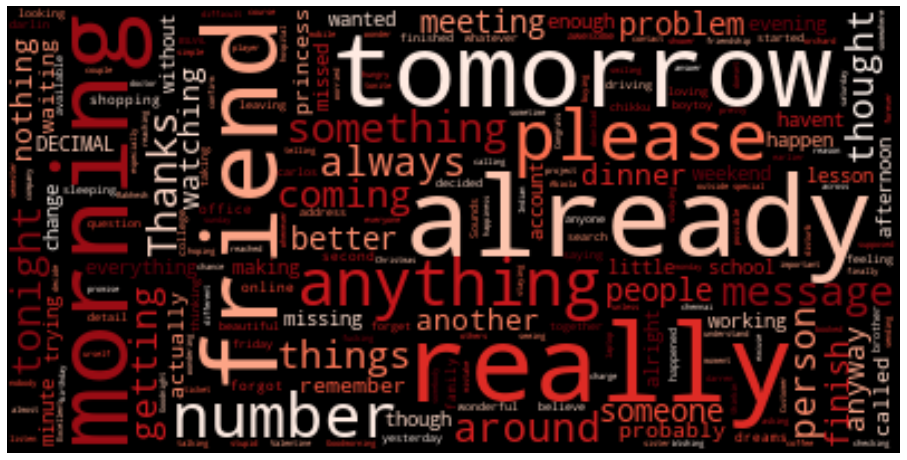

In [9]:
# wordcloud of ham messages
ham_msg_cloud = WordCloud(width =400, height =200, stopwords=STOPWORDS,max_font_size=50, background_color ="black", colormap='Reds', min_word_length=6).generate(ham_msg_text)
plt.figure(figsize=(16,10))
plt.imshow(ham_msg_cloud, interpolation='bilinear')
plt.axis('off') 
plt.show()

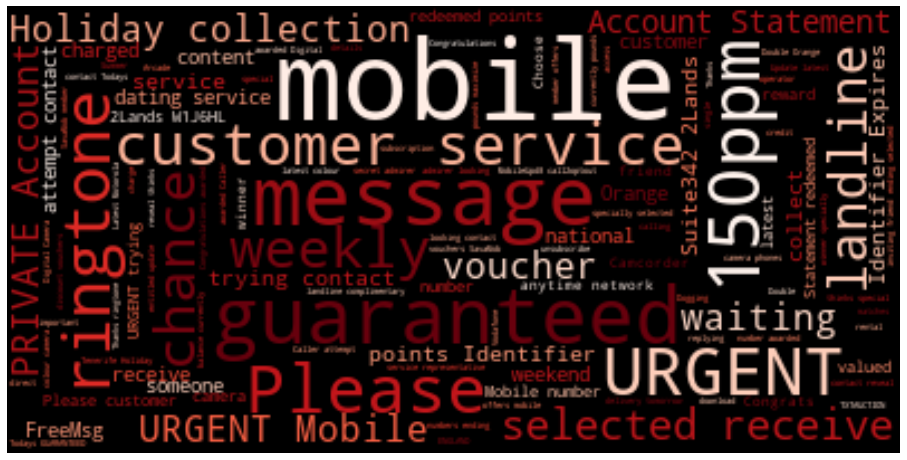

In [10]:
# wordcloud of spam messages
spam_msg_cloud = WordCloud(width =400, height =200, stopwords=STOPWORDS,max_font_size=50, background_color ="black", colormap='Reds', min_word_length=6).generate(spam_msg_text)
plt.figure(figsize=(16,10))
plt.imshow(spam_msg_cloud, interpolation='bilinear')
plt.axis('off') 
plt.show()

Let's visualize our labels a bit more with different visualization options

C:\Users\musta\Anaconda3\envs\rstudio\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


15.481865284974095

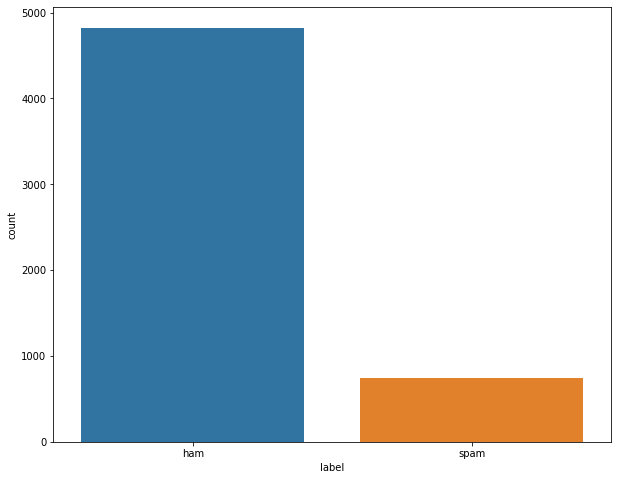

In [11]:
# we can observe imbalance data here 
plt.figure(figsize=(10,8))
sns.countplot(messages.label)
# Percentage of spam messages
(len(spam_message)/len(ham_message))*100 ##percentage of the spam mails

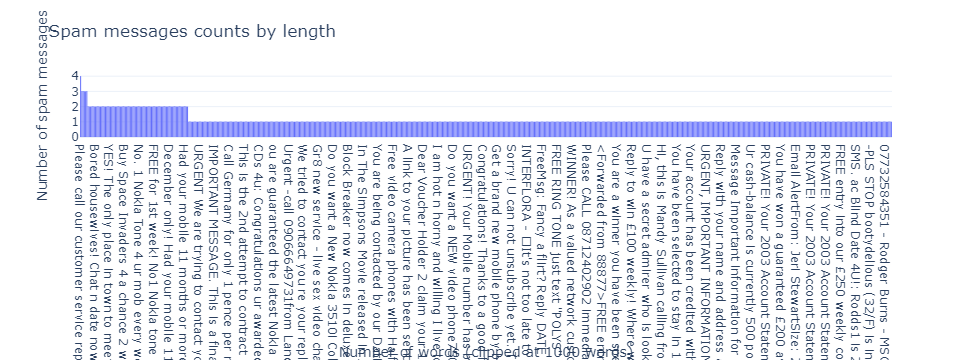

In [12]:
import plotly.express as px
fig = px.histogram(spam_message, x='message', template='plotly_white', title='Spam messages counts by length')
fig.update_xaxes(categoryorder='total descending', title='Number of words (clipped at 1000 words)').update_yaxes(title='Number of spam messages')
fig.show()

#for this dataset plotly.express is not the best visualization library but still we can use it 

- Having imbalance data may cause problems for our analyze and we should figure out imbalance data problem.
- One of the method would be downsampling which means matching the numbers in majority and minority classes
- The problem with the imbalance data is that models trained on unbalanced datasets often have poor results when they have to generalize (predict a class or classify unseen observations)

In [13]:
ham_msg_df = ham_message.sample(n = len(spam_message), random_state = 10) # we can have the same amount of value which is equal to the spam label with sample 
spam_msg_df = spam_message
print(ham_msg_df.shape, spam_msg_df.shape)

(747, 2) (747, 2)


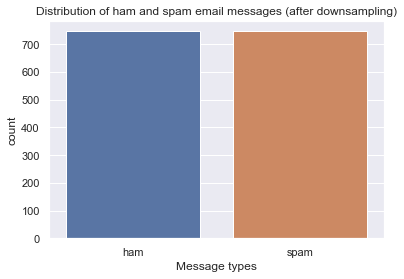

In [14]:
import matplotlib.pyplot as plt
msg_df = ham_msg_df.append(spam_msg_df).reset_index(drop=True)  # we again concat the dataset of the ham and spam messages

%matplotlib inline
sns.set(style="darkgrid")
ax = sns.countplot(x='label',  data=msg_df)
plt.title('Distribution of ham and spam email messages (after downsampling)')
plt.xlabel('Message types')
plt.show()


In [15]:
# Get length column for each text
msg_df['text_length'] = msg_df['message'].apply(len)
#Calculate average length by label types
labels = msg_df.groupby('label').mean()
labels

text_length
label             
ham      71.361446
spam    138.670683

Prepare train/test data and pre-process text


In [16]:
# Map ham label as 0 and spam as 1
msg_df['message_type']= msg_df['label'].apply(lambda x: 1 if x=='spam' else 0)
msg_label = msg_df['message_type'].values
msg_label

array([0, 0, 0, ..., 1, 1, 1], dtype=int64)

In [17]:
# Split data into train and test
train_msg, test_msg, train_labels, test_labels = train_test_split(msg_df['message'], msg_label, test_size=0.2)

Tokenization

Deep learning models do not understand text, we need to convert text into numerical representation. For this purpose, a first step is Tokenization. The Tokenizer API from TensorFlow Keras splits sentences into words and encodes these into integers.

In [18]:
# Defining pre-processing hyperparameters
max_len = 50 
trunc_type = "post" 
padding_type = "post" 
oov_tok = "<OOV>" 
vocab_size = 500
#filter -> may be used, by default filters our all punctuation terms (!”#$%&()*+,-./:;<=>?@[\]^_’{|}~\t\n).
#num_words: Limits maximum number of most popular words to keep while training.
# oov_tok (out of vocabulary): When its used, out of vocabulary token will be added to word index in the corpus which is used to build the model.
#This is used to replace out of vocabulary words (words that are not in our corpus) during text_to_sequence calls (see below).

In [19]:
tokenizer = Tokenizer(num_words = vocab_size, char_level=False, oov_token = oov_tok)  #char_level : if True, every character will be treated as a token.
tokenizer.fit_on_texts(train_msg)

In [20]:
# Get the word_index 
#word_index: Convert all words to integer index. Full list of words are available as key value property: key = word and value = token for that word
word_index = tokenizer.word_index
word_index

{'<OOV>': 1,
 'to': 2,
 'you': 3,
 'a': 4,
 'i': 5,
 'call': 6,
 'the': 7,
 'u': 8,
 'your': 9,
 'for': 10,
 'is': 11,
 'and': 12,
 '2': 13,
 'now': 14,
 'free': 15,
 'or': 16,
 'in': 17,
 'on': 18,
 'have': 19,
 'ur': 20,
 'of': 21,
 'with': 22,
 'from': 23,
 'txt': 24,
 'me': 25,
 '4': 26,
 'are': 27,
 'stop': 28,
 'get': 29,
 'text': 30,
 'mobile': 31,
 'this': 32,
 'just': 33,
 'it': 34,
 'claim': 35,
 'reply': 36,
 'will': 37,
 'be': 38,
 'only': 39,
 'send': 40,
 'my': 41,
 'can': 42,
 'www': 43,
 'no': 44,
 'prize': 45,
 'we': 46,
 'our': 47,
 'at': 48,
 'if': 49,
 'that': 50,
 'do': 51,
 'out': 52,
 'so': 53,
 'not': 54,
 'cash': 55,
 'but': 56,
 'new': 57,
 'won': 58,
 'go': 59,
 'please': 60,
 'all': 61,
 '150p': 62,
 "i'm": 63,
 'uk': 64,
 'up': 65,
 'week': 66,
 '1': 67,
 't': 68,
 'nokia': 69,
 'day': 70,
 'urgent': 71,
 'win': 72,
 'want': 73,
 'msg': 74,
 'phone': 75,
 'contact': 76,
 'com': 77,
 'co': 78,
 '18': 79,
 'know': 80,
 '50': 81,
 'what': 82,
 'ok': 83,
 'by':

In [21]:
# check how many words 
tot_words = len(word_index)
print('There are %s unique tokens in training data. ' % tot_words)

There are 4202 unique tokens in training data. 


Sequencing 

Next, let’s represent each sentence by sequences of numbers using texts_to_sequences from tokenizer object. Below, we printed out raw sentences, word index and sequences.
Sequencing example
 - ['I want to go out', ' I like to play', ' No eating - ', 'No play!']
 - {'<OOV>': 1, 'i': 2, 'to': 3, 'play': 4, 'no': 5, 'want': 6, 'go': 7, 'out': 8, 'like': 9, 'eating': 10}
 - [[2, 6, 3, 7, 8], [2, 9, 3, 4], [5, 10], [5, 4]]

Padding 
- In any raw text data, naturally there will be sentences of different lengths. However, all neural networks require to have inputs with the same size. For this purpose, padding is done.
- Below, let’s use pad_sequences for padding. pad_sequences uses arguments such as sequences, padding, maxlen, truncating, value and dtype.
- sequences: list of sequences that we created earlier
- padding = ‘pre’ or ‘post (default pre). By using pre, we’ll pad (add 0) before each sequence and post will pad after each sequence.
- maxlen = maximum length of all sequences. If not provided, by default it will use the maximum length of the longest sentence.
- truncating = ‘pre’ or ‘post’ (default ‘pre’). If a sequence length is larger than the provided maxlen value then, these values will be truncated to the maxlen. ‘pre’ option will truncate at the beginning whereas ‘post’ will truncate at the end of the sequences.
- value: padding value (default is 0)
- dtype: output sequence type (default is int32)

In [22]:
# Sequencing and padding on training and testing 
training_sequences = tokenizer.texts_to_sequences(train_msg)
training_padded = pad_sequences (training_sequences, maxlen = max_len, padding = padding_type, truncating = trunc_type )
testing_sequences = tokenizer.texts_to_sequences(test_msg)
testing_padded = pad_sequences(testing_sequences, maxlen = max_len,
padding = padding_type, truncating = trunc_type)

In [23]:
# Shape of train tensor
print('Shape of training tensor: ', training_padded.shape)
print('Shape of testing tensor: ', testing_padded.shape)

Shape of training tensor:  (1195, 50)
Shape of testing tensor:  (299, 50)


In [24]:
print(training_padded[0]) #now our all sequences have 50 words and we are using trunch type post (so we have zeros at the end)

[259 259   1  12  30  25 278   1  12   1  12   1  10 330   1   8  65  10
 330 279  32  74  11  15   1   1  62   1   1  13   1  30  28   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]


 ## Spam Detection Dense Model

In [25]:
#hyper parameter
vocab_size = 500 # As defined earlier
embeding_dim = 16
drop_value = 0.2 # dropout
n_dense = 24

In [26]:
#Dense model architecture
model = Sequential() # calls for Keras sequential model in which layers are added in a sequence. Now we can add the following layers.
model.add(Embedding(vocab_size, embeding_dim, input_length=max_len)) 
#1. layer embeding layer to map N-dimensional vector to real numbers.
#The embedding layer indicates that the two words with a similar meaning tend to have very close vectors.
#embeding_dim : size of the vector
model.add(GlobalAveragePooling1D())
#2. layer is for to avoid overfitting by reducing the number of the parameters. But I have used the average pooling and converted 1 dimension layer
model.add(Dense(24, activation='relu'))
#3. layer dense layer with rectified linear units (ReLU) activation function.
model.add(Dropout(drop_value))
model.add(Dense(1, activation='sigmoid')) 
#Here 1 means that I will have only single output neuron 1 or 0 because the mail would be spam or ham. Also this is the reason I am using sigmoid activation
# 0 or 1 

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 16)            8000      
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 24)                408       
                                                                 
 dropout (Dropout)           (None, 24)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 25        
                                                                 
Total params: 8,433
Trainable params: 8,433
Non-trainable params: 0
______________________________________________________

Compiling the Dense model


In [28]:
model.compile(loss='binary_crossentropy',optimizer='adam' ,metrics=['accuracy'])
#BinaryCrossentropy : This is the crossentropy metric class to be used when there are only two label classes (0 and 1).

Training and evaluating the Dense model


In [29]:
# fitting a dense spam detector model
num_epochs = 20
early_stop = EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(training_padded, train_labels, epochs=num_epochs, validation_data=(testing_padded, test_labels),callbacks =[early_stop], verbose=2)

Epoch 1/20
38/38 - 1s - loss: 0.6897 - accuracy: 0.7088 - val_loss: 0.6839 - val_accuracy: 0.8896 - 1s/epoch - 29ms/step
Epoch 2/20
38/38 - 0s - loss: 0.6769 - accuracy: 0.8343 - val_loss: 0.6639 - val_accuracy: 0.8930 - 128ms/epoch - 3ms/step
Epoch 3/20
38/38 - 0s - loss: 0.6482 - accuracy: 0.8577 - val_loss: 0.6197 - val_accuracy: 0.8963 - 148ms/epoch - 4ms/step
Epoch 4/20
38/38 - 0s - loss: 0.5934 - accuracy: 0.8862 - val_loss: 0.5452 - val_accuracy: 0.8997 - 171ms/epoch - 4ms/step
Epoch 5/20
38/38 - 0s - loss: 0.5130 - accuracy: 0.8854 - val_loss: 0.4471 - val_accuracy: 0.9064 - 173ms/epoch - 5ms/step
Epoch 6/20
38/38 - 0s - loss: 0.4206 - accuracy: 0.8979 - val_loss: 0.3596 - val_accuracy: 0.9164 - 165ms/epoch - 4ms/step
Epoch 7/20
38/38 - 0s - loss: 0.3455 - accuracy: 0.9079 - val_loss: 0.2955 - val_accuracy: 0.9164 - 106ms/epoch - 3ms/step
Epoch 8/20
38/38 - 0s - loss: 0.2922 - accuracy: 0.9163 - val_loss: 0.2472 - val_accuracy: 0.9264 - 93ms/epoch - 2ms/step
Epoch 9/20
38/38 - 

In [30]:
# Model performance on test data 
model.evaluate(testing_padded, test_labels)

10/10 [==============================] - 0s 2ms/step - loss: 0.1202 - accuracy: 0.9532


[0.12019559741020203, 0.953177273273468]

We can further visualize the history results by plotting loss and accuracy by number of epochs.

In [31]:
# Read as a dataframe 
metrics = pd.DataFrame(history.history)
# Rename column
metrics.rename(columns = {'loss': 'Training_Loss', 'accuracy': 'Training_Accuracy', 'val_loss': 'Validation_Loss', 'val_accuracy': 'Validation_Accuracy'}, inplace = True)
def plot_graphs1(var1, var2, string):
    metrics[[var1, var2]].plot()
    plt.title('Training and Validation ' + string)
    plt.xlabel ('Number of epochs')
    plt.ylabel(string)
    plt.legend([var1, var2])

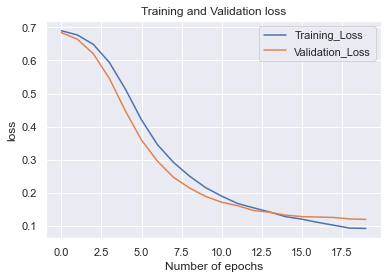

In [32]:
plot_graphs1('Training_Loss', 'Validation_Loss', 'loss')


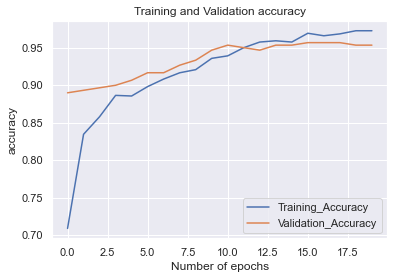

In [33]:
plot_graphs1('Training_Accuracy', 'Validation_Accuracy', 'accuracy')


In [72]:
#Confusion Matrix
y_predicted_1 = model.predict(testing_padded)
y_predicted_1 = y_predicted_1.flatten()

In [74]:
y_predicted_1 = np.where(y_predicted_1 > 0.5, 1, 0)
con_mat_1 = confusion_matrix(test_labels, y_predicted_1)
con_mat_1 

array([[146,   2],
       [ 12, 139]], dtype=int64)

Text(30.5, 0.5, 'Real Data')

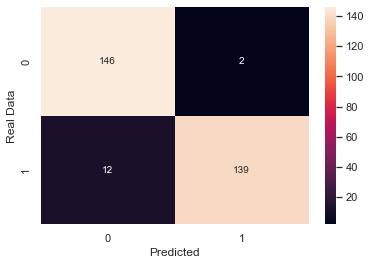

In [38]:

sns.heatmap(con_mat_1, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Real Data')

## Long Short Term Memory (LSTM) Model


I could use the RNN (Recurrent Neural Networks) but they are not good enough to work with long sentences. Because we don't have cell stae for RNN. So I prefered to use LSTM which has
both cell states and a hidden states. With cell state LSTM can maintain information in memory for long periods of time.

In [39]:
#LSTM hyperparameters
n_lstm = 20  #number of nodes in the hidden layers within the LSTM cell
drop_lstm =0.2 #dropout layer helps to avoid overfitting in training by bypassing randomly selected neurons, thereby reducing the sensitivity to specific weights of the individual neurons. 
                #A good starting point is 20% but the dropout value should be kept small (up to 50%). The 20% value is widely accepted as 
                #the best compromise between preventing model overfitting and retaining model accuracy.

In [92]:
#LSTM Spam detection architecture
model_first = Sequential()
model_first.add(Embedding(vocab_size, embeding_dim, input_length=max_len))
model_first.add(LSTM(n_lstm, dropout=drop_lstm, return_sequences=True))
model_first.add(LSTM(n_lstm, dropout=drop_lstm))
model_first.add(Dense(1, activation='relu'))

In [93]:
model_first.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])

#binary_crossentropy: Used as a loss function for binary classification model. The binary_crossentropy function computes the cross-entropy loss between true labels and predicted labels.
#categorical_crossentropy: Used as a loss function for multi-class classification model where there are two or more output labels.

In [94]:
num_epochs = 25
early_stop = EarlyStopping(monitor='val_loss', patience=2)
history = model_first.fit(training_padded, train_labels, epochs=num_epochs, validation_data=(testing_padded, test_labels),callbacks =[early_stop], verbose=2)

Epoch 1/25
38/38 - 6s - loss: 0.8319 - accuracy: 0.5038 - val_loss: 0.6951 - val_accuracy: 0.4950 - 6s/epoch - 160ms/step
Epoch 2/25
38/38 - 2s - loss: 0.6509 - accuracy: 0.6259 - val_loss: 0.4507 - val_accuracy: 0.8930 - 2s/epoch - 40ms/step
Epoch 3/25
38/38 - 2s - loss: 0.3158 - accuracy: 0.9155 - val_loss: 0.2627 - val_accuracy: 0.9532 - 2s/epoch - 40ms/step
Epoch 4/25
38/38 - 2s - loss: 0.2552 - accuracy: 0.9632 - val_loss: 0.1995 - val_accuracy: 0.9599 - 2s/epoch - 41ms/step
Epoch 5/25
38/38 - 2s - loss: 0.3530 - accuracy: 0.9280 - val_loss: 0.2644 - val_accuracy: 0.9599 - 2s/epoch - 40ms/step
Epoch 6/25
38/38 - 2s - loss: 0.2980 - accuracy: 0.9063 - val_loss: 0.2802 - val_accuracy: 0.9632 - 2s/epoch - 40ms/step


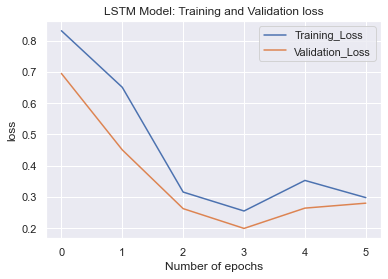

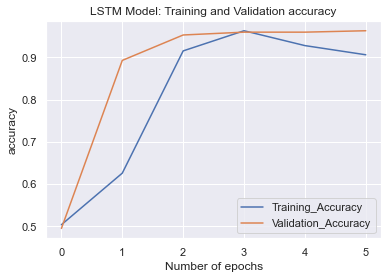

In [95]:
# Create a dataframe
metrics = pd.DataFrame(history.history)
# Rename column
metrics.rename(columns = {'loss': 'Training_Loss', 'accuracy': 'Training_Accuracy',
                         'val_loss': 'Validation_Loss', 'val_accuracy': 'Validation_Accuracy'}, inplace = True)
def plot_graphs1(var1, var2, string):
    metrics[[var1, var2]].plot()
    plt.title('LSTM Model: Training and Validation ' + string)
    plt.xlabel ('Number of epochs')
    plt.ylabel(string)
    plt.legend([var1, var2])
plot_graphs1('Training_Loss', 'Validation_Loss', 'loss')
plot_graphs1('Training_Accuracy', 'Validation_Accuracy', 'accuracy')

In [96]:
model_first.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 50, 16)            8000      
                                                                 
 lstm_7 (LSTM)               (None, 50, 20)            2960      
                                                                 
 lstm_8 (LSTM)               (None, 20)                3280      
                                                                 
 dense_4 (Dense)             (None, 1)                 21        
                                                                 
Total params: 14,261
Trainable params: 14,261
Non-trainable params: 0
_________________________________________________________________


In [98]:
#Confusion Matrix
y_predicted_2 = model_first.predict(testing_padded)
y_predicted_2 = y_predicted_2.flatten()

In [100]:
y_predicted_2 = np.where(y_predicted_2 > 0.5, 1, 0)
con_mat_2 = confusion_matrix(test_labels, y_predicted_2)
con_mat_2 

array([[145,   3],
       [  8, 143]], dtype=int64)

Text(30.5, 0.5, 'Real Data')

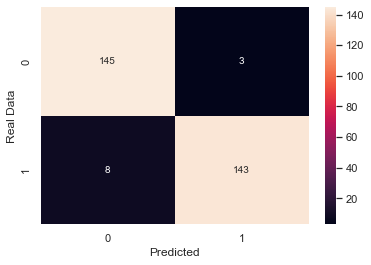

In [101]:
sns.heatmap(con_mat_2, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Real Data')

## Bi-directional Long Short Term Memory (BiLSTM) Model
- learns patterns from both before and after a given token within a document
- back-propagates in both backward and forward directions in time
- disadvantage: the computational time is increased compared to LSTM
- Generally better accuracy

In [105]:
# Biderectional LSTM Spam detection architecture
model_second = Sequential()
model_second.add(Embedding(vocab_size, embeding_dim, input_length=max_len))
model_second.add(Bidirectional(LSTM(n_lstm, dropout=drop_lstm)))
model_second.add(Dense(1, activation='relu'))

In [106]:
model_second.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])

In [107]:
# Training
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=2)
history = model_second.fit(training_padded, train_labels, epochs=num_epochs, 
                    validation_data=(testing_padded, test_labels),callbacks =[early_stop], verbose=2)

Epoch 1/30
38/38 - 6s - loss: 0.8926 - accuracy: 0.5423 - val_loss: 0.5289 - val_accuracy: 0.7860 - 6s/epoch - 159ms/step
Epoch 2/30
38/38 - 1s - loss: 0.4062 - accuracy: 0.8795 - val_loss: 0.2418 - val_accuracy: 0.9431 - 1s/epoch - 31ms/step
Epoch 3/30
38/38 - 1s - loss: 0.2040 - accuracy: 0.9272 - val_loss: 0.1528 - val_accuracy: 0.9532 - 1s/epoch - 27ms/step
Epoch 4/30
38/38 - 1s - loss: 0.1208 - accuracy: 0.9523 - val_loss: 0.1530 - val_accuracy: 0.9565 - 1s/epoch - 31ms/step
Epoch 5/30
38/38 - 1s - loss: 0.0901 - accuracy: 0.9682 - val_loss: 0.1854 - val_accuracy: 0.9632 - 1s/epoch - 37ms/step


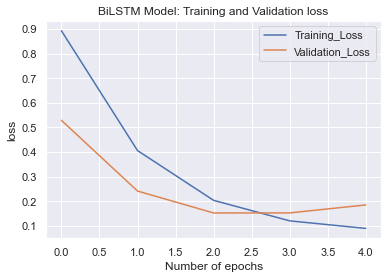

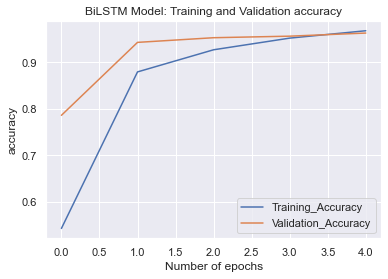

In [108]:
# Create a dataframe
metrics = pd.DataFrame(history.history)
# Rename column
metrics.rename(columns = {'loss': 'Training_Loss', 'accuracy': 'Training_Accuracy',
                         'val_loss': 'Validation_Loss', 'val_accuracy': 'Validation_Accuracy'}, inplace = True)
def plot_graphs1(var1, var2, string):
    metrics[[var1, var2]].plot()
    plt.title('BiLSTM Model: Training and Validation ' + string)
    plt.xlabel ('Number of epochs')
    plt.ylabel(string)
    plt.legend([var1, var2])
# Plot
plot_graphs1('Training_Loss', 'Validation_Loss', 'loss')
plot_graphs1('Training_Accuracy', 'Validation_Accuracy', 'accuracy')

In [112]:
model_second.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 50, 16)            8000      
                                                                 
 bidirectional_2 (Bidirectio  (None, 40)               5920      
 nal)                                                            
                                                                 
 dense_6 (Dense)             (None, 1)                 41        
                                                                 
Total params: 13,961
Trainable params: 13,961
Non-trainable params: 0
_________________________________________________________________


In [109]:
#Confusion Matrix
y_predicted_3 = model_second.predict(testing_padded)
y_predicted_3 = y_predicted_3.flatten()

In [110]:
y_predicted_3 = np.where(y_predicted_3 > 0.5, 1, 0)
con_mat_3 = confusion_matrix(test_labels, y_predicted_3)
con_mat_3 

array([[147,   1],
       [ 10, 141]], dtype=int64)

Text(30.5, 0.5, 'Real Data')

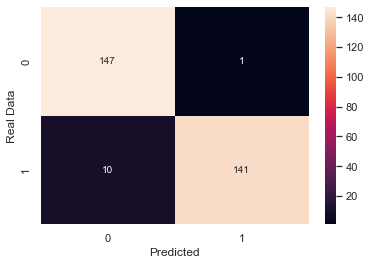

In [111]:
sns.heatmap(con_mat_3, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Real Data')

## BERT MODEL SPAM DETECTION

In [43]:
import tensorflow_hub as hub
import tensorflow_text as tex


In [44]:
preprocess = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3')
encoder = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4')

In [45]:
def get_sentence_embeding (sentence):
    preprocessed_text = preprocess(sentence)
    return encoder(preprocessed_text)['pooled_output']

I will use functional model instead of sequential model  
https://becominghuman.ai/sequential-vs-functional-model-in-keras-20684f766057

In [48]:
#train test split
X_train, X_test, y_train, y_test = train_test_split(msg_df['message'],msg_label, stratify=msg_label)


In [50]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = preprocess(text_input)
outputs = encoder(preprocessed_text)

In [51]:
# Neural network layers
layer = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
layer = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(layer)

In [52]:
# Use inputs and outputs to construct a final model
model_third = tf.keras.Model(inputs=[text_input], outputs = [layer])

In [53]:
model_third.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_type_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                      

In [56]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

In [58]:
#trainig
model_third.fit(X_train, y_train, epochs=10)

Epoch 1/10
35/35 [==============================] - 739s 21s/step - loss: 0.6144 - accuracy: 0.6777 - precision: 0.6749 - recall: 0.6857
Epoch 2/10
35/35 [==============================] - 742s 21s/step - loss: 0.5051 - accuracy: 0.8152 - precision: 0.7927 - recall: 0.8536
Epoch 3/10
35/35 [==============================] - 729s 21s/step - loss: 0.4400 - accuracy: 0.8518 - precision: 0.8493 - recall: 0.8554
Epoch 4/10
35/35 [==============================] - 741s 21s/step - loss: 0.3965 - accuracy: 0.8652 - precision: 0.8484 - recall: 0.8893
Epoch 5/10
35/35 [==============================] - 628s 18s/step - loss: 0.3647 - accuracy: 0.8750 - precision: 0.8646 - recall: 0.8893
Epoch 6/10
35/35 [==============================] - 492s 14s/step - loss: 0.3449 - accuracy: 0.8884 - precision: 0.8822 - recall: 0.8964
Epoch 7/10
35/35 [==============================] - 382s 11s/step - loss: 0.3140 - accuracy: 0.9009 - precision: 0.8812 - recall: 0.9268
Epoch 8/10
35/35 [=======================

In [62]:
y_predicted = model_third.predict(X_test)
y_predicted = y_predicted.flatten()

In [63]:
from sklearn.metrics import confusion_matrix, classification_report

y_predicted = np.where(y_predicted > 0.5, 1, 0)
con_mat = confusion_matrix(y_test, y_predicted)
con_mat 

array([[176,  11],
       [  7, 180]], dtype=int64)

Text(30.5, 0.5, 'Real Data')

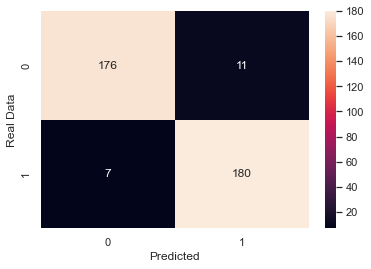

In [66]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(con_mat, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Real Data')

In [67]:
print(classification_report(y_test, y_predicted))


              precision    recall  f1-score   support

           0       0.96      0.94      0.95       187
           1       0.94      0.96      0.95       187

    accuracy                           0.95       374
   macro avg       0.95      0.95      0.95       374
weighted avg       0.95      0.95      0.95       374

